In [7]:
#ProstateX final 

#Andrii Trokoz



'''
Importing all the necessary libraries and frameworks in order to start image processing 
'''
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
import warnings


def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [42]:
#reading .csv in order to get all of necessary coordinates for cropping 
data_image = pd.read_csv('C://Image Processing/ProstateX-TestLesionInformation/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv')

data_image.head(20)


,ProxID,Name,fid,pos,WorldMatrix,ijk,TopLevel,SpacingBetweenSlices,VoxelSpacing,Dim,DCMSerDescr,DCMSerNum
0,ProstateX-0000,ep2d_diff_tra_DYNDIST_ADC0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST_ADC,7
1,ProstateX-0000,ep2d_diff_tra_DYNDIST0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
2,ProstateX-0000,ep2d_diff_tra_DYNDIST1,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
3,ProstateX-0000,ep2d_diff_tra_DYNDIST2,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
4,ProstateX-0000,ep2d_diff_tra_DYNDISTCALC_BVAL0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDISTCALC_BVAL,8
5,ProstateX-0000,t2_tse_cor0,1,25.7457 31.8707 -38.511,"0.6,0,0,-57.5639,0,-0.190383,2.84497,29.839,0,...",139 166 12,1.0,3.0000,"0.6,0.6,3",320x320x15x1,t2_tse_cor,5
6,ProstateX-0000,t2_tse_sag0,1,25.7457 31.8707 -38.511,"0,0,-3.6,73.1629,0.5625,0,0,-67.018,0,-0.5625,...",176 169 13,1.0,3.6000,"0.5625,0.5625,3.6",320x320x19x1,t2_tse_sag,3
7,ProstateX-0000,t2_tse_tra0,1,25.7457 31.8707 -38.511,"0.5,1.00168e-010,0.00377059,-57.9373,-0.000199...",167 224 9,1.0,3.0000,"0.5,0.5,3",384x384x19x1,t2_tse_tra,4
8,ProstateX-0000,tfl_3d_PD_ref_tra_1_5x1_5_t30,1,25.7457 31.8707 -38.511,"1.5,3.00503e-010,0.00377059,-58.4317,-0.000597...",56 75 7,1.0,3.0000,"1.5,1.5,3",128x128x16x1,tfl_3d PD ref_tra_1.5x1.5_t3,9
9,ProstateX-0001,ep2d_diff_tra_DYNDIST_MIX_ADC0,1,-40.5367071921656 29.320722668457 -16.70766907...,"2,4.10207e-010,-4.64581e-017,-107.955,-4.0773e...",34 63 10,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST_MIX_ADC,8


In [51]:
#Extracting the names of each image for the further processing from Data Frame, we need this to match names of files with pos coordinates
data_image.loc[:,'match'] = '' #creates new column where we`ll put the matching names 

for i in range(len(data_new)):  #names for further matching with images` names
    data_image.loc[i,'match'] = data_image.loc[i,'DCMSerDescr']+'_' + data_image.loc[i,'ProxID'].replace('-','_')+'.nii.gz'

    
    
data_image.loc[:,('match','Name','ProxID')].head(5)

,match,Name,ProxID
0,ep2d_diff_tra_DYNDIST_ADC_ProstateX_0000.nii.gz,ep2d_diff_tra_DYNDIST_ADC0,ProstateX-0000
1,ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz,ep2d_diff_tra_DYNDIST0,ProstateX-0000
2,ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz,ep2d_diff_tra_DYNDIST1,ProstateX-0000
3,ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz,ep2d_diff_tra_DYNDIST2,ProstateX-0000
4,ep2d_diff_tra_DYNDISTCALC_BVAL_ProstateX_0000....,ep2d_diff_tra_DYNDISTCALC_BVAL0,ProstateX-0000


In [138]:
'''
Creating separate DataFrames for each of modalites. 

It is going to be: t2_df, adc_df, bval_df and ktrans_df

'''


#Creating a DataFrame with names of files that matches the names of our t2 sequences 

t2_dir=os.listdir('C://Image Processing/ProstateX/resampled/')

t2_match = [i for i in t2_dir if 't2' in i ]

#t2 = [i[:-12]+'.nii.gz' for i in t2_match if i.split('_')[-1][0] != '0']
#t2 = [t2[i] for i in range(len(t2)) if t2[i]==t2[i-1]]

def make_match_list(directory, matching_value): 
    #generating a list of matching names
    match=[i for i in directory if matching_value in i]
    for i in range(len(match)): 
        if match[i].split('_')[-1][0] !='0':
            match[i]=match[i][:-12] + '.nii.gz'
        if match[i]==match[i-1]:
            
    return match

#t2_macth

#Creating new DataFrame for t2_tra only

#df[df['A'].isin([3, 6])]
#t2_df = data_image[data_image['match'].isin('t2' and 'tra')]




make_match_list(t2_dir,'t2')



['4_t2_ts.nii.gz',
 't2_tse_tra_320_p2_ProstateX_0218.nii.gz',
 't2_tse_tra_exacte_copy_diffusie_ProstateX_0032.nii.gz',
 't2_tse_tra_Grappa3_ProstateX_0191.nii.gz',
 't2_tse_tra_ProstateX_0000.nii.gz',
 't2_tse_tra_ProstateX_0001.nii.gz',
 't2_tse_tra_ProstateX_0001.nii.gz',
 't2_tse_tra_ProstateX_0002.nii.gz',
 't2_tse_tra_ProstateX_0003.nii.gz',
 't2_tse_tra_ProstateX_0004.nii.gz',
 't2_tse_tra_ProstateX_0005.nii.gz',
 't2_tse_tra_ProstateX_0006.nii.gz',
 't2_tse_tra_ProstateX_0007.nii.gz',
 't2_tse_tra_ProstateX_0008.nii.gz',
 't2_tse_tra_ProstateX_0009.nii.gz',
 't2_tse_tra_ProstateX_0010.nii.gz',
 't2_tse_tra_ProstateX_0010.nii.gz',
 't2_tse_tra_ProstateX_0011.nii.gz',
 't2_tse_tra_ProstateX_0011.nii.gz',
 't2_tse_tra_ProstateX_0012.nii.gz',
 't2_tse_tra_ProstateX_0013.nii.gz',
 't2_tse_tra_ProstateX_0014.nii.gz',
 't2_tse_tra_ProstateX_0015.nii.gz',
 't2_tse_tra_ProstateX_0016.nii.gz',
 't2_tse_tra_ProstateX_0017.nii.gz',
 't2_tse_tra_ProstateX_0018.nii.gz',
 't2_tse_tra_Prostat

In [134]:
t2

['t2_tse_tra_ProstateX_0001.nii.gz',
 't2_tse_tra_ProstateX_0010.nii.gz',
 't2_tse_tra_ProstateX_0011.nii.gz',
 't2_tse_tra_ProstateX_0019.nii.gz',
 't2_tse_tra_ProstateX_0031.nii.gz',
 't2_tse_tra_ProstateX_0034.nii.gz',
 't2_tse_tra_ProstateX_0042.nii.gz',
 't2_tse_tra_ProstateX_0052.nii.gz',
 't2_tse_tra_ProstateX_0054.nii.gz',
 't2_tse_tra_ProstateX_0061.nii.gz',
 't2_tse_tra_ProstateX_0074.nii.gz',
 't2_tse_tra_ProstateX_0074.nii.gz',
 't2_tse_tra_ProstateX_0077.nii.gz',
 't2_tse_tra_ProstateX_0079.nii.gz',
 't2_tse_tra_ProstateX_0095.nii.gz',
 't2_tse_tra_ProstateX_0097.nii.gz',
 't2_tse_tra_ProstateX_0098.nii.gz',
 't2_tse_tra_ProstateX_0099.nii.gz',
 't2_tse_tra_ProstateX_0101.nii.gz',
 't2_tse_tra_ProstateX_0102.nii.gz',
 't2_tse_tra_ProstateX_0105.nii.gz',
 't2_tse_tra_ProstateX_0112.nii.gz',
 't2_tse_tra_ProstateX_0113.nii.gz',
 't2_tse_tra_ProstateX_0114.nii.gz',
 't2_tse_tra_ProstateX_0116.nii.gz',
 't2_tse_tra_ProstateX_0122.nii.gz',
 't2_tse_tra_ProstateX_0123.nii.gz',
 

In [130]:
t2_no_du = []

for i in range(len(t2)):
    if t2[i] == t2[i-1]:
        t2_no_du.append(t2[i])
    else:
        pass
len(t2_no_du)    

82

In [49]:
data_image.loc[:,'match']

0         ep2d_diff_tra_DYNDIST_ADC_ProstateX_0000.nii.gz
1             ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz
2             ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz
3             ep2d_diff_tra_DYNDIST_ProstateX_0000.nii.gz
4       ep2d_diff_tra_DYNDISTCALC_BVAL_ProstateX_0000....
5                        t2_tse_cor_ProstateX_0000.nii.gz
6                        t2_tse_sag_ProstateX_0000.nii.gz
7                        t2_tse_tra_ProstateX_0000.nii.gz
8       tfl_3d PD ref_tra_1.5x1.5_t3_ProstateX_0000.ni...
9       ep2d_diff_tra_DYNDIST_MIX_ADC_ProstateX_0001.n...
10        ep2d_diff_tra_DYNDIST_MIX_ProstateX_0001.nii.gz
11        ep2d_diff_tra_DYNDIST_MIX_ProstateX_0001.nii.gz
12        ep2d_diff_tra_DYNDIST_MIX_ProstateX_0001.nii.gz
13      ep2d_diff_tra_DYNDIST_MIXCALC_BVAL_ProstateX_0...
14                       t2_loc sag_ProstateX_0001.nii.gz
15                     t2_localizer_ProstateX_0001.nii.gz
16                     t2_localizer_ProstateX_0001.nii.gz
17            

In [48]:
t2_df.loc[:,'match']

7               t2_tse_tra_ProstateX_0000.nii.gz
40              t2_tse_tra_ProstateX_0002.nii.gz
41              t2_tse_tra_ProstateX_0002.nii.gz
60              t2_tse_tra_ProstateX_0003.nii.gz
61              t2_tse_tra_ProstateX_0003.nii.gz
71              t2_tse_tra_ProstateX_0004.nii.gz
94              t2_tse_tra_ProstateX_0005.nii.gz
95              t2_tse_tra_ProstateX_0005.nii.gz
96              t2_tse_tra_ProstateX_0005.nii.gz
118             t2_tse_tra_ProstateX_0006.nii.gz
119             t2_tse_tra_ProstateX_0006.nii.gz
132             t2_tse_tra_ProstateX_0007.nii.gz
144             t2_tse_tra_ProstateX_0008.nii.gz
155             t2_tse_tra_ProstateX_0009.nii.gz
199             t2_tse_tra_ProstateX_0012.nii.gz
200             t2_tse_tra_ProstateX_0012.nii.gz
212             t2_tse_tra_ProstateX_0013.nii.gz
221             t2_tse_tra_ProstateX_0014.nii.gz
230             t2_tse_tra_ProstateX_0015.nii.gz
241             t2_tse_tra_ProstateX_0016.nii.gz
252             t2_t

432

In [273]:
folder = 'C://Image Processing/ProstateX/resampled/'
directory = os.listdir(folder)

directory
matching_dict = {i: i for i in data_all['ProxID'] if i.split('-')[-1] in [i for i in directory]}



{}

In [276]:
for i in data_all['ProxID']:
    for y in directory:
        if i.split('-')[-1] in y:
            print('{} filename for further reading is {}'.format(i,y))

ProstateX-0000 filename for further reading is ep2d_diff_tra_DYNDISTCALC_BVAL_ProstateX_0000.nii.gz
ProstateX-0000 filename for further reading is ep2d_diff_tra_DYNDIST_ADC_ProstateX_0000.nii.gz
ProstateX-0000 filename for further reading is ProstateX-0000-Ktrans.mhd
ProstateX-0000 filename for further reading is ProstateX-0000-Ktrans.raw
ProstateX-0000 filename for further reading is t2_tse_tra_ProstateX_0000.nii.gz
ProstateX-0001 filename for further reading is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL_ProstateX_0001.nii.gz
ProstateX-0001 filename for further reading is ep2d_diff_tra_DYNDIST_MIX_ADC_ProstateX_0001.nii.gz
ProstateX-0001 filename for further reading is ProstateX-0001-Ktrans.mhd
ProstateX-0001 filename for further reading is ProstateX-0001-Ktrans.raw
ProstateX-0001 filename for further reading is t2_tse_tra_ProstateX_0001_s006.nii.gz
ProstateX-0001 filename for further reading is t2_tse_tra_ProstateX_0001_s010.nii.gz
ProstateX-0002 filename for further reading is ep2d_diff_tra

ProstateX-0100 filename for further reading is ep2d_diff_tra_DYNDIST_ADC_ProstateX_0100.nii.gz
ProstateX-0100 filename for further reading is ProstateX-0100-Ktrans.mhd
ProstateX-0100 filename for further reading is ProstateX-0100-Ktrans.raw
ProstateX-0100 filename for further reading is t2_tse_tra_ProstateX_0100.nii.gz
ProstateX-0101 filename for further reading is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL_ProstateX_0101.nii.gz
ProstateX-0101 filename for further reading is ep2d_diff_tra_DYNDIST_MIX_ADC_ProstateX_0101.nii.gz
ProstateX-0101 filename for further reading is ProstateX-0101-Ktrans.mhd
ProstateX-0101 filename for further reading is ProstateX-0101-Ktrans.raw
ProstateX-0101 filename for further reading is t2_tse_tra_ProstateX_0101_s004.nii.gz
ProstateX-0101 filename for further reading is t2_tse_tra_ProstateX_0101_s006.nii.gz
ProstateX-0101 filename for further reading is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL_ProstateX_0101.nii.gz
ProstateX-0101 filename for further reading is ep2d_diff

ProstateX-0152 filename for further reading is ProstateX-0152-Ktrans.raw
ProstateX-0152 filename for further reading is t2_tse_tra_ProstateX_0152_s004.nii.gz
ProstateX-0152 filename for further reading is t2_tse_tra_ProstateX_0152_s009.nii.gz
ProstateX-0153 filename for further reading is ep2d_diff_tra_DYNDISTCALC_BVAL_ProstateX_0153.nii.gz
ProstateX-0153 filename for further reading is ep2d_diff_tra_DYNDIST_ADC_ProstateX_0153.nii.gz
ProstateX-0153 filename for further reading is ProstateX-0153-Ktrans.mhd
ProstateX-0153 filename for further reading is ProstateX-0153-Ktrans.raw
ProstateX-0153 filename for further reading is t2_tse_tra_ProstateX_0153_s004.nii.gz
ProstateX-0153 filename for further reading is t2_tse_tra_ProstateX_0153_s060.nii.gz
ProstateX-0153 filename for further reading is ep2d_diff_tra_DYNDISTCALC_BVAL_ProstateX_0153.nii.gz
ProstateX-0153 filename for further reading is ep2d_diff_tra_DYNDIST_ADC_ProstateX_0153.nii.gz
ProstateX-0153 filename for further reading is Pros

In [275]:
matching_dict = {i: k for i in data_all['ProxID'] for k in directory if i.split('-')[-1] in k}

matching_dict

{'ProstateX-0000': 't2_tse_tra_ProstateX_0000.nii.gz',
 'ProstateX-0001': 't2_tse_tra_ProstateX_0001_s010.nii.gz',
 'ProstateX-0002': 't2_tse_tra_ProstateX_0002.nii.gz',
 'ProstateX-0003': 't2_tse_tra_ProstateX_0003.nii.gz',
 'ProstateX-0004': 't2_tse_tra_ProstateX_0004.nii.gz',
 'ProstateX-0005': 't2_tse_tra_ProstateX_0005.nii.gz',
 'ProstateX-0006': 't2_tse_tra_ProstateX_0006.nii.gz',
 'ProstateX-0007': 't2_tse_tra_ProstateX_0007.nii.gz',
 'ProstateX-0008': 't2_tse_tra_ProstateX_0008.nii.gz',
 'ProstateX-0009': 't2_tse_tra_ProstateX_0009.nii.gz',
 'ProstateX-0010': 't2_tse_tra_ProstateX_0010_s006.nii.gz',
 'ProstateX-0011': 't2_tse_tra_ProstateX_0011_s006.nii.gz',
 'ProstateX-0012': 't2_tse_tra_ProstateX_0012.nii.gz',
 'ProstateX-0013': 't2_tse_tra_ProstateX_0013.nii.gz',
 'ProstateX-0014': 't2_tse_tra_ProstateX_0014.nii.gz',
 'ProstateX-0015': 't2_tse_tra_ProstateX_0015.nii.gz',
 'ProstateX-0016': 't2_tse_tra_ProstateX_0016.nii.gz',
 'ProstateX-0017': 't2_tse_tra_ProstateX_0017.nii.

In [ ]:
#Making new column with physical coordinates of the findings 
#In order to do that we should first read image, than get pos and finally transfer physical point to index

#first of all we should match ProxID and read image 

#for reading image we have to undestand which image to read, get its path and match it with correct pos

#find ProxID -- find filename -- match proxid with filename -- find pos -- read image -- transform image pos to index

def phys_to_index_col(data, folder):
    directory = os.listdir(folder)
    for i in directory: 
        for k in data['ProxID']:
            if k.split('-')[-1] in i: 
                pos=[float(i) for i in (data['pos'].loc[data['ProxID']==k][0]).split(' ')]
                im = sitk.ReadImage(folder+i)
                data['index'].loc[data['ProxID']==k]=im.TransformPhysicalPointToIndex(pos)



In [304]:
a=[float(i) for i in (data_all['pos'].loc[data['ProxID']=='ProstateX-0000'][0]).split(' ')]

data_new['ProxID'][1]
data_new.loc[data_new['ProxID']=='ProstateX-0002'].index[0]

a

[25.7457, 31.8707, -38.511]

In [287]:
data_all['pos'].loc[data['ProxID']=='ProstateX-0191']
directory

['4_t2_tse_tra.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL_Prosta.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL_Prosta_s008.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL_Prosta_s009.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL_Prosta_s010.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC_ProstateX_0.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC_ProstateX_0_s007.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC_ProstateX_0_s008.nii.gz',
 'diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC_ProstateX_0_s009.nii.gz',
 'ep2d_diff_tra2x2_Noise0_FS_DYNDISTCALC_BVAL_ProstateX_0191_s005.nii.gz',
 'ep2d_diff_tra2x2_Noise0_FS_DYNDISTCALC_BVAL_ProstateX_0191_s013.nii.gz',
 'ep2d_diff_tra2x2_Noise0_FS_DYNDIST_ADC_ProstateX_0191_s004.nii.gz',
 'ep2d_diff_tra2x2_Noise0_FS_DYNDIST_ADC_ProstateX_0191_s012.nii.gz',
 'ep2d_diff_tra2x2_Noise0_NoFS_DYNDISTCALC_BVAL_ProstateX_01.nii.gz',
 'ep2d_diff_tra2x2_Noise0_

In [299]:
for i in directory:
    for k in data_all['ProxID']:
        if k.split('-')[-1] in i: 
            print(k)
            pos=[float(i) for i in (data_all['pos'].loc[data_all['ProxID']==k][data_all.loc[data['ProxID']==k].index[0]]).split(' ')]
            print(pos)


ProstateX-0191
[20.7818, 18.0177, -0.799461]
ProstateX-0191
[20.7818, 18.0177, -0.799461]
ProstateX-0191
[20.7818, 18.0177, -0.799461]
ProstateX-0191
[20.7818, 18.0177, -0.799461]
ProstateX-0191
[20.7818, 18.0177, -0.799461]
ProstateX-0000
[25.7457, 31.8707, -38.511]
ProstateX-0002
[-27.0102, 41.5467, -26.0469]
ProstateX-0002
[-27.0102, 41.5467, -26.0469]
ProstateX-0003
[22.1495, 31.2717, -2.45933]
ProstateX-0003
[22.1495, 31.2717, -2.45933]
ProstateX-0006
[8.20024, 28.2665, -10.4784]
ProstateX-0006
[8.20024, 28.2665, -10.4784]
ProstateX-0007
[-5.4258, 20.1075, -57.34]
ProstateX-0008
[25.2302, 38.6613, -26.864]
ProstateX-0009
[19.565, 32.8037, -37.4421]
ProstateX-0010
[-31.8128, 51.364, -56.0047]
ProstateX-0011
[9.29795, 10.7009, 14.2935]
ProstateX-0012
[4.08778, 49.7898, -3.71828]
ProstateX-0012
[4.08778, 49.7898, -3.71828]
ProstateX-0016
[-17.4648, 10.7487, -1.55198]
ProstateX-0017
[2.89097, 49.4408, -14.4697]
ProstateX-0018
[4.08917, 18.7769, -11.5951]
ProstateX-0020
[10.1617, 53.59

[-19.9140532625499, 31.4812375854275, 41.345622424212]
ProstateX-0173
[-19.6271, 40.7648, -22.8634]
ProstateX-0173
[-19.6271, 40.7648, -22.8634]
ProstateX-0174
[9.31972, 11.9806, 2.38443]
ProstateX-0175
[21.0113, 20.9077, -25.4179]
ProstateX-0175
[21.0113, 20.9077, -25.4179]
ProstateX-0176
[20.4698, 19.123, 4.52906]
ProstateX-0176
[20.4698, 19.123, 4.52906]
ProstateX-0178
[22.7777, 9.97451, -65.0748]
ProstateX-0179
[-27.6234, 23.8724, -20.1605]
ProstateX-0179
[-27.6234, 23.8724, -20.1605]
ProstateX-0180
[-41.1698, 34.6176, 45.2961]
ProstateX-0181
[-14.47804, 8.02319, 12.0739]
ProstateX-0182
[13.1275, 41.7624, -17.9265]
ProstateX-0183
[21.4663, 46.1903, -28.381]
ProstateX-0184
[8.75216, 26.8913, -82.9706]
ProstateX-0184
[8.75216, 26.8913, -82.9706]
ProstateX-0185
[-36.5467, 15.7218, 22.3888]
ProstateX-0187
[15.6411, 12.9549, -36.1184]
ProstateX-0187
[15.6411, 12.9549, -36.1184]
ProstateX-0187
[15.6411, 12.9549, -36.1184]
ProstateX-0188
[-28.3426, 16.8586, -14.8499]
ProstateX-0189
[18.41

[32.1001, 22.5752, 25.9394]
ProstateX-0142
[32.1001, 22.5752, 25.9394]
ProstateX-0143
[-20.0928, 14.9006, 23.5027]
ProstateX-0144
[-8.56937, 40.4973, -41.5161]
ProstateX-0144
[-8.56937, 40.4973, -41.5161]
ProstateX-0144
[-8.56937, 40.4973, -41.5161]
ProstateX-0147
[-33.4804, 41.3495, -25.21]
ProstateX-0147
[-33.4804, 41.3495, -25.21]
ProstateX-0148
[13.2424, 27.3962, 10.5819]
ProstateX-0148
[13.2424, 27.3962, 10.5819]
ProstateX-0149
[19.0337, 63.5321, 14.5746]
ProstateX-0149
[19.0337, 63.5321, 14.5746]
ProstateX-0150
[-9.84748672851562, 11.7404424609375, 30.3737125732422]
ProstateX-0150
[-9.84748672851562, 11.7404424609375, 30.3737125732422]
ProstateX-0151
[-19.8161, 35.8201, -65.2786]
ProstateX-0151
[-19.8161, 35.8201, -65.2786]
ProstateX-0152
[4.73273, 22.4072, -77.2909]
ProstateX-0153
[42.0601, 33.9525, 17.631]
ProstateX-0153
[42.0601, 33.9525, 17.631]
ProstateX-0153
[42.0601, 33.9525, 17.631]
ProstateX-0154
[-45.5195, 53.9119, 33.6642]
ProstateX-0154
[-45.5195, 53.9119, 33.6642]
Pr

ValueError: could not convert string to float: 

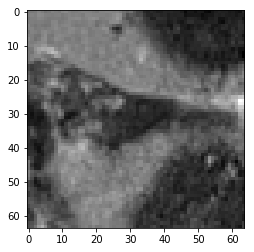

In [188]:
extract = sitk.ExtractImageFilter()
extract.SetSize([64,64,0])
extract.SetIndex([153-20, 166-32, 12])
extracted = extract.Execute(im)

extr_arr = sitk.GetArrayFromImage(extracted)
plt.imshow(extr_arr,cmap='gray')

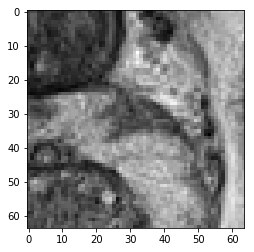

In [190]:
extract = sitk.ExtractImageFilter()
extract.SetSize([64,64,0])
extract.SetIndex([203-20, 168-32, 9])
extracted = extract.Execute(im)

extr_arr = sitk.GetArrayFromImage(extracted)
plt.imshow(extr_arr,cmap='gray')



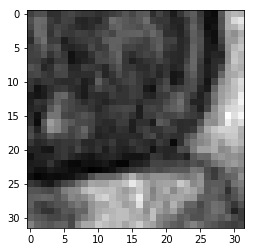

In [191]:
im = sitk.ReadImage('C://Image Processing/ProstateX/t2/t2_tse_tra_ProstateX_0002.nii')
im_arr = sitk.GetArrayFromImage(im)
im_sl_9 = im_arr[9,:,:]
im_sl_9 = sitk.GetImageFromArray(im_sl_9)

extract = sitk.ExtractImageFilter()
extract.SetSize([32,32])
extract.SetIndex([203-20, 168-32])
extracted_image = extract.Execute(im_sl_9)


extrcated_arr = sitk.GetArrayFromImage(extracted_image)

plt.imshow(extrcated_arr, cmap = 'gray')

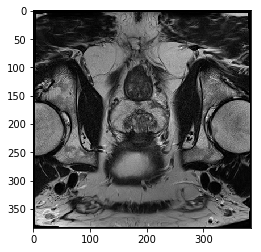

In [119]:
myshow(im_arr,9)

In [184]:
pos = [-27.0102, 41.5467, -26.0469]
ijk = im.TransformPhysicalPointToIndex(pos)

print(ijk)

(153, 166, 12)


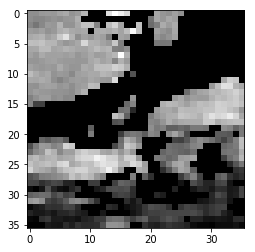

In [114]:
im = sitk.ReadImage('C://Image Processing/ProstateX/resampled/ep2d_diff_tra_DYNDIST_ADC_ProstateX_0000.nii')
im_arr = sitk.GetArrayFromImage(im)

im_sl_8 = im_arr[9,:,:]
im_sl_8 = sitk.GetImageFromArray(im_sl_8)

extract = sitk.ExtractImageFilter()
extract.SetSize([36,36])
extract.SetIndex([36, 72 ])
extracted_image = extract.Execute(im_sl_8)


extrcated_arr = sitk.GetArrayFromImage(extracted_image)

plt.imshow(extrcated_arr, cmap = 'gray')

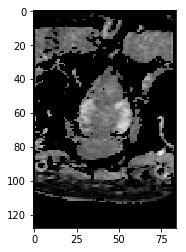

In [115]:
myshow(im_arr,9)

In [183]:
data_all.loc[data_all['ProxID']=='ProstateX-0002']

,ProxID,Name,fid,pos,WorldMatrix,ijk,TopLevel,SpacingBetweenSlices,VoxelSpacing,Dim,DCMSerDescr,DCMSerNum
22,ProstateX-0002,ep2d_diff_tra_DYNDIST_ADC0,2,-2.058 38.6752 -34.6104,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",45 70 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST_ADC,7
23,ProstateX-0002,ep2d_diff_tra_DYNDIST_ADC0,1,-27.0102 41.5467 -26.0469,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",33 71 12,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST_ADC,7
24,ProstateX-0002,ep2d_diff_tra_DYNDIST0,2,-2.058 38.6752 -34.6104,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",45 70 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
25,ProstateX-0002,ep2d_diff_tra_DYNDIST0,1,-27.0102 41.5467 -26.0469,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",33 71 12,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
26,ProstateX-0002,ep2d_diff_tra_DYNDIST1,2,-2.058 38.6752 -34.6104,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",45 70 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
27,ProstateX-0002,ep2d_diff_tra_DYNDIST1,1,-27.0102 41.5467 -26.0469,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",33 71 12,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
28,ProstateX-0002,ep2d_diff_tra_DYNDIST2,2,-2.058 38.6752 -34.6104,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",45 70 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
29,ProstateX-0002,ep2d_diff_tra_DYNDIST2,1,-27.0102 41.5467 -26.0469,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",33 71 12,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
30,ProstateX-0002,ep2d_diff_tra_DYNDISTCALC_BVAL0,2,-2.058 38.6752 -34.6104,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",45 70 9,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDISTCALC_BVAL,8
31,ProstateX-0002,ep2d_diff_tra_DYNDISTCALC_BVAL0,1,-27.0102 41.5467 -26.0469,"2,4.10207e-010,7.98512e-017,-92.5336,-3.98536e...",33 71 12,1.0,3.0000,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDISTCALC_BVAL,8
